# Ames Housing Dataset

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import scipy
import math

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate

##Regressors
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

##Settings
pd.options.display.max_rows = 30
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.4f}'.format
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

In [3]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
df =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
df["LSalePrice"]=np.log(df["SalePrice"])
temp=df.columns.values.tolist()
temp.remove("SalePrice")
temp.remove("LSalePrice")
col=["SalePrice","LSalePrice"]+temp
df=df[col]

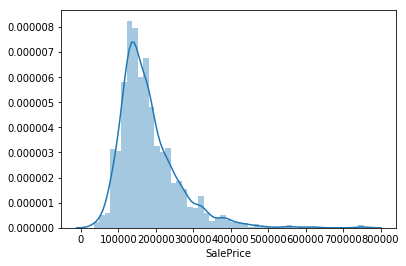

In [4]:
sns.distplot(train["SalePrice"])

In [5]:
df.head()

,SalePrice,LSalePrice,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,Id,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,208500.0000,12.2477,856,854,0,NaN,3,1Fam,TA,No,706.0000,0.0000,GLQ,Unf,1.0000,0.0000,Gd,150.0000,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,NaN,0,PConc,2,Typ,548.0000,2.0000,TA,RFn,TA,Attchd,2003.0000,1710,1,GasA,Ex,2Story,1,1,Gd,Lvl,Gtl,8450,Inside,65.0000,Reg,0,60,RL,196.0000,BrkFace,NaN,0,2,CollgCr,61,5,7,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,8,856.0000,AllPub,0,2003,2003,2008
1,181500.0000,12.1090,1262,0,0,NaN,3,1Fam,TA,Gd,978.0000,0.0000,ALQ,Unf,0.0000,1.0000,Gd,284.0000,Y,Feedr,Norm,SBrkr,0,TA,TA,MetalSd,MetalSd,NaN,TA,1,CBlock,2,Typ,460.0000,2.0000,TA,RFn,TA,Attchd,1976.0000,1262,0,GasA,Ex,1Story,2,1,TA,Lvl,Gtl,9600,FR2,80.0000,Reg,0,20,RL,0.0000,None,NaN,0,5,Veenker,0,8,6,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,6,1262.0000,AllPub,298,1976,1976,2007
2,223500.0000,12.3172,920,866,0,NaN,3,1Fam,TA,Mn,486.0000,0.0000,GLQ,Unf,1.0000,0.0000,Gd,434.0000,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,TA,1,PConc,2,Typ,608.0000,2.0000,TA,RFn,TA,Attchd,2001.0000,1786,1,GasA,Ex,2Story,3,1,Gd,Lvl,Gtl,11250,Inside,68.0000,IR1,0,60,RL,162.0000,BrkFace,NaN,0,9,CollgCr,42,5,7,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,6,920.0000,AllPub,0,2001,2002,2008
3,140000.0000,11.8494,961,756,0,NaN,3,1Fam,Gd,No,216.0000,0.0000,ALQ,Unf,1.0000,0.0000,TA,540.0000,Y,Norm,Norm,SBrkr,272,TA,TA,Wd Sdng,Wd Shng,NaN,Gd,1,BrkTil,1,Typ,642.0000,3.0000,TA,Unf,TA,Detchd,1998.0000,1717,0,GasA,Gd,2Story,4,1,Gd,Lvl,Gtl,9550,Corner,60.0000,IR1,0,70,RL,0.0000,None,NaN,0,2,Crawfor,35,5,7,Y,0,NaN,CompShg,Gable,Abnorml,WD,0,Pave,7,756.0000,AllPub,0,1915,1970,2006
4,250000.0000,12.4292,1145,1053,0,NaN,4,1Fam,TA,Av,655.0000,0.0000,GLQ,Unf,1.0000,0.0000,Gd,490.0000,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,TA,1,PConc,2,Typ,836.0000,3.0000,TA,RFn,TA,Attchd,2000.0000,2198,1,GasA,Ex,2Story,5,1,Gd,Lvl,Gtl,14260,FR2,84.0000,IR1,0,60,RL,350.0000,BrkFace,NaN,0,12,NoRidge,84,5,8,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,9,1145.0000,AllPub,192,2000,2000,2008


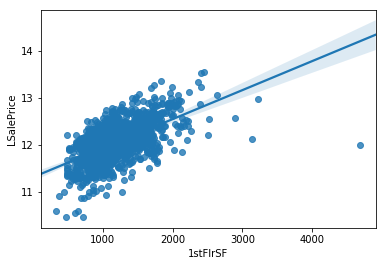

In [6]:
p=sns.regplot(x="1stFlrSF",y="LSalePrice",data=df)

### Preprocessing

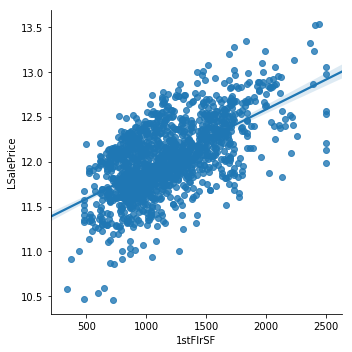

In [7]:
def clip(dataframe,feature,maximum):
    index=dataframe[dataframe[feature]>maximum].index.values
    dataframe.loc[index,feature]=maximum
    return dataframe    
df=clip(df,"1stFlrSF",2500)
g=sns.lmplot(x="1stFlrSF",y="LSalePrice",data=df)

### Filling missing values

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
SalePrice        1460 non-null float64
LSalePrice       1460 non-null float64
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            2919 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2919 non-null object
BsmtExposure     2919 non-null object
BsmtFinSF1       2919 non-null float64
BsmtFinSF2       2919 non-null float64
BsmtFinType1     2919 non-null object
BsmtFinType2     2919 non-null object
BsmtFullBath     2919 non-null float64
BsmtHalfBath     2919 non-null float64
BsmtQual         2919 non-null object
BsmtUnfSF        2919 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2919 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        

In [45]:
df["BsmtQual"][0]

'Gd'

In [9]:
tofill=["BsmtFullBath","BsmtHalfBath","GarageArea","GarageCars","MasVnrArea","TotalBsmtSF","BsmtUnfSF"]
for i in tofill:
    df[i].fillna(df[i].median(),inplace=True)

In [10]:
del df["Utilities"]

In [11]:
tofill2=["SaleType","MSZoning","MasVnrType","KitchenQual","Functional","Exterior1st","Exterior2nd","Electrical"]
for j in tofill2:
    df[j].fillna(df[j].value_counts().idxmax(),inplace=True)

In [12]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df[col].fillna("None",inplace=True)

In [13]:
df["Alley"].fillna("None",inplace=True)

In [14]:
df["BsmtCond"].fillna("TA",inplace=True)

In [15]:
df["BsmtExposure"].fillna("Av",inplace=True)

In [16]:
df["PoolQC"].fillna("None",inplace=True)

In [17]:
df["MiscFeature"] = df["MiscFeature"].fillna("None")

In [18]:
df["Fence"] = df["Fence"].fillna("None")

In [19]:
df["FireplaceQu"] = df["FireplaceQu"].fillna("None")

In [20]:
df["BsmtFinSF1"].fillna(df["BsmtFinSF1"].median(),inplace=True)
df["BsmtFinSF2"].fillna(df["BsmtFinSF2"].median(),inplace=True)

In [21]:
df["LotFrontage"]=df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [22]:
for k in ["BsmtFinType1","BsmtFinType2","BsmtQual"]:
    df[k].fillna("None",inplace=True)

In [23]:
df["GarageYrBlt"].fillna(0,inplace=True)

In [41]:
df["MoSold"]=df["MoSold"].astype(str)

In [42]:
df["YrSold"]=df["YrSold"].astype(str)

In [43]:
df["MSSubClass"]=df["MSSubClass"].astype(str)

In [46]:
del df["LSalePrice"]

### Model

In [47]:
df_dummies=pd.get_dummies(data=df)
train_dummies=df_dummies[:1460]
test_dummies=df_dummies[1460:]
X=train_dummies.drop(columns="SalePrice")
y=train_dummies["SalePrice"].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
print("X_train shape: %d x %d." % (X_train.shape[0],X_train.shape[1]))
print("X_test shape: %d x %d." % (X_test.shape[0],X_test.shape[1]))

X_train shape: 1095 x 329.
X_test shape: 365 x 329.


In [50]:
def root_mean_squared_error(truth,predictions):
    return np.sqrt(sum((truth-predictions) ** 2)/len(truth))
rmse_scorer=make_scorer(root_mean_squared_error,greater_is_better=False)

In [69]:
regr=[LinearRegression(),Lasso(alpha=1),Ridge(alpha=0.01),XGBRegressor(max_depth=5),RandomForestRegressor()]

In [76]:
Lasso().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [79]:
def cross_validation(regr=regr,X_train=X_train,y_train=np.log(y_train),scoring=rmse_scorer,cv=3,
                   table=True):
    names=[]
    mean_test_scores=[]
    test_stds=[]
    mean_train_scores=[]
    train_stds=[]
    coef=[]
    outcomes={}
    
    
    for r in regr:
        name=r.__class__.__name__
        names.append(name)
        outcomes[name]=cross_validate(r,X_train,y_train,scoring=scoring,cv=cv)
        
        mean_test_scores.append(outcomes[name]["test_score"].mean())
        test_stds.append(outcomes[name]["test_score"].std())
        mean_train_scores.append(outcomes[name]["train_score"].mean())
        train_stds.append(outcomes[name]["train_score"].std())
        
        r.fit(X_train,y_train)
        
        if name in ["LinearRegression","Lasso","Ridge"]:
            coef.append(r.coef_)
    
    
    regr_results=pd.DataFrame({"Regressor":names,"Mean train score":mean_train_scores,\
                               "Train std":train_stds,"Mean test score":mean_test_scores,\
                                "test_std":test_stds},index=np.arange(len(names)))
    if table:
        display(regr_results)
    
    results=pd.DataFrame({"Features":X_train.columns.values,"LinearRegression":coef[0],"Lasso":coef[1],\
                          "Ridge":coef[2]}).sort_values(by="Lasso",ascending=False)
    sns.barplot(x="Features",y="Lasso",data=results)
    plt.xticks(rotation=90)
    plt.title("Strongest weights Lasso")
    return outcomes,results

,Regressor,Mean train score,Train std,Mean test score,test_std
0,LinearRegression,-0.0763,0.0018,-5.5062,7.5489
1,Lasso,-0.1749,0.0036,-0.1918,0.0270
2,Ridge,-0.0764,0.0018,-0.1829,0.0292
3,XGBRegressor,-0.0443,0.0010,-0.1368,0.0055
4,RandomForestRegressor,-0.0692,0.0007,-0.1599,0.0171


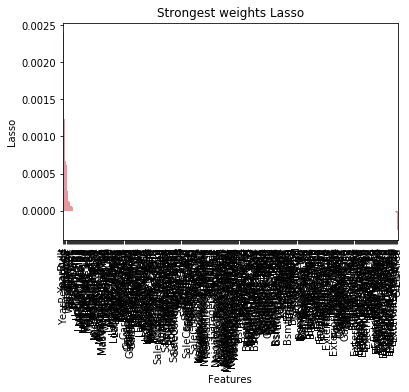

In [80]:
outcomes,results=cross_validation()

In [78]:
outcomes

{'LinearRegression': {'fit_time': array([0.05294585, 0.05794573, 0.04295921, 0.04196095, 0.04295969,
         0.05894613, 0.05494738, 0.05394959, 0.05894542, 0.04995346]),
  'score_time': array([0.0009985 , 0.00100017, 0.00099969, 0.00099921, 0.        ,
         0.        , 0.00099969, 0.        , 0.00099826, 0.        ]),
  'test_score': array([-3.53539914e+02, -1.22127883e-01, -2.02285800e-01, -1.26293334e+02,
         -2.46831378e+01, -1.79926926e-01, -1.22272710e-01, -2.21854174e-01,
         -1.40354921e-01, -9.61928694e-02]),
  'train_score': array([-0.08490538, -0.08724925, -0.08330355, -0.08305409, -0.08373239,
         -0.08376072, -0.08676755, -0.08104785, -0.08529414, -0.088634  ])},
 'Lasso': {'fit_time': array([0.07792783, 0.07493043, 0.0709343 , 0.08891845, 0.07593012,
         0.1358695 , 0.13188052, 0.10690165, 0.12289023, 0.13387871]),
  'score_time': array([0.        , 0.00100064, 0.        , 0.        , 0.00099897,
         0.0009985 , 0.00099826, 0.00099611, 0.0009

In [77]:
results

,Features,LinearRegression,Lasso,Ridge
32,YearBuilt,0.0023,0.0024,0.0023
33,YearRemodAdd,0.0010,0.0012,0.0010
0,1stFlrSF,0.0009,0.0007,0.0009
1,2ndFlrSF,0.0008,0.0006,0.0009
12,GarageArea,0.0001,0.0003,0.0001
30,TotalBsmtSF,0.0001,0.0001,0.0001
31,WoodDeckSF,0.0001,0.0001,0.0001
14,GarageYrBlt,-0.0002,0.0001,-0.0002
28,ScreenPorch,0.0002,0.0001,0.0002
4,BsmtFinSF1,0.0001,0.0001,0.0001


In [460]:
results.set_index("Features").filter(like="Neigh",axis=0)

,LinearRegression,Lasso,Ridge
Features,,,
Neighborhood_StoneBr,0.2726,0.2621,0.2532
Neighborhood_Veenker,0.2099,0.1959,0.1857
Neighborhood_NridgHt,0.1980,0.1920,0.1888
Neighborhood_NoRidge,0.1779,0.1715,0.1683
Neighborhood_Somerst,0.1342,0.1284,0.1286
Neighborhood_ClearCr,0.1289,0.1274,0.1284
Neighborhood_Crawfor,0.1043,0.1079,0.1083
Neighborhood_Timber,0.0975,0.0925,0.0929
Neighborhood_NPkVill,0.0852,0.0658,0.0738


### Test set

In [28]:
r=XGBRegressor()
r.fit(X_train[features],np.log(y_train))
pred=r.predict(X_test[features])
root_mean_squared_error(np.log(y_test),pred)

0.1744528856141417

### Outcome

In [29]:
test_dummies.head()

,SalePrice,LSalePrice,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,Condition2,EnclosedPorch,ExterCond,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,GarageArea,GarageCars,GarageCond,GarageFinish,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,Id,KitchenAbvGr,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,...,YearRemodAdd_1994,YearRemodAdd_1995,YearRemodAdd_1996,YearRemodAdd_1997,YearRemodAdd_1998,YearRemodAdd_1999,YearRemodAdd_2000,YearRemodAdd_2001,YearRemodAdd_2002,YearRemodAdd_2003,YearRemodAdd_2004,YearRemodAdd_2005,YearRemodAdd_2006,YearRemodAdd_2007,YearRemodAdd_2008,YearRemodAdd_2009,YearRemodAdd_2010,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA
1460,nan,nan,896,0,0,NaN,2,TA,No,468.0000,144.0000,Rec,LwQ,0.0000,0.0000,TA,270.0000,Norm,0,TA,VinylSd,VinylSd,MnPrv,NaN,0,CBlock,1,730.0000,1.0000,TA,Unf,Attchd,1961.0000,896,0,GasA,1461,1,Lvl,Gtl,11622,Inside,80.0000,Reg,0,0.0000,None,NaN,0,6,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
1461,nan,nan,1329,0,0,NaN,3,TA,No,923.0000,0.0000,ALQ,Unf,0.0000,0.0000,TA,406.0000,Norm,0,TA,Wd Sdng,Wd Sdng,NaN,NaN,0,CBlock,1,312.0000,1.0000,TA,Unf,Attchd,1958.0000,1329,1,GasA,1462,1,Lvl,Gtl,14267,Corner,81.0000,IR1,0,108.0000,BrkFace,Gar2,12500,6,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1
1462,nan,nan,928,701,0,NaN,3,TA,No,791.0000,0.0000,GLQ,Unf,0.0000,0.0000,Gd,137.0000,Norm,0,TA,VinylSd,VinylSd,MnPrv,TA,1,PConc,2,482.0000,2.0000,TA,Fin,Attchd,1997.0000,1629,1,GasA,1463,1,Lvl,Gtl,13830,Inside,74.0000,IR1,0,0.0000,None,NaN,0,3,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1
1463,nan,nan,926,678,0,NaN,3,TA,No,602.0000,0.0000,GLQ,Unf,0.0000,0.0000,TA,324.0000,Norm,0,TA,VinylSd,VinylSd,NaN,Gd,1,PConc,2,470.0000,2.0000,TA,Fin,Attchd,1998.0000,1604,1,GasA,1464,1,Lvl,Gtl,9978,Inside,78.0000,IR1,0,20.0000,BrkFace,NaN,0,6,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1
1464,nan,nan,1280,0,0,NaN,2,TA,No,263.0000,0.0000,ALQ,Unf,0.0000,0.0000,Gd,1017.0000,Norm,0,TA,HdBoard,HdBoard,NaN,NaN,0,PConc,2,506.0000,2.0000,TA,RFn,Attchd,1992.0000,1280,0,GasA,1465,1,HLS,Gtl,5005,Inside,43.0000,IR1,0,0.0000,None,NaN,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0


In [30]:
test_x=test_dummies[features]

In [31]:
reg=XGBRegressor()

In [32]:
reg.fit(X[features],np.log(y))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [33]:
pred_test=reg.predict(test_x[features])

In [34]:
final=np.e ** pred_test

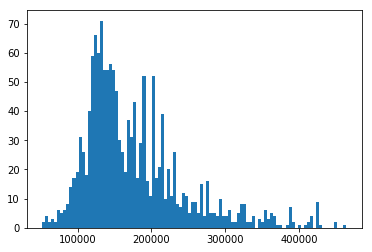

In [35]:
plt.hist(final,bins=100)
plt.show()

In [36]:
submission=pd.DataFrame({"Id":np.arange(1461,2920),"SalePrice":final})

In [37]:
submission.to_csv("ThirdSubmissionAmes.csv",index=False)